In [73]:
import numpy as np
import pandas as pd
import plotly.express as px

In [2]:
df_tm = pd.read_excel('Draft_TM.xlsx', sheet_name = "Draft_Monolingual")
df_sa = pd.read_csv('Draft_SA.csv')
df_map = pd.read_excel('Draft_Mapping.xlsx')

In [74]:
df = df_tm.copy()
df = df.merge(df_sa[['CGID', 'label', 'score']],
              on = 'CGID')
df = df.merge(df_map[['Topic', 'Primary_Driver', 'Secondary_Driver', 'New_Category', 'Keyword']],
              left_on = 'Revised_Topic',
              right_on = 'Topic')
df.rename(columns = {'label': 'Sentiment_Label',
                     'score': 'Sentiment_Score',
                     'Topic_x': 'Old_Topic'}, inplace = True)
df.drop(['Topic_y'], axis = 1, inplace = True)
print(df.columns)

Index(['CGID', 'Survey_Completed_Date', 'CustomerNumber', 'HeinekenRegion',
       'Country', 'CustomerCluster', 'BusinessSegment', 'CustomerType',
       'NetPromoterScore', 'Reasons_List', 'Comment', 'Comment_Translation',
       'Old_Topic', 'Revised_Topic', 'Sentiment_Label', 'Sentiment_Score',
       'Primary_Driver', 'Secondary_Driver', 'New_Category', 'Keyword'],
      dtype='object')


In [75]:
condlist = [
    df['NetPromoterScore'] == -1,
    (df['NetPromoterScore'] >= 0) & (df['NetPromoterScore'] <= 6),
    (df['NetPromoterScore'] >= 7) & (df['NetPromoterScore'] <= 8),
    df['NetPromoterScore'] >= 9]
choicelist = ['CSAT', 'Detractor', 'Passive', 'Promoter']
df['NPS_Class'] = np.select(condlist, choicelist, default='Unknown')
print(set(df['Sentiment_Label'].tolist()))

{'negative', 'neutral', 'positive'}


In [76]:
def check_driver_in_reasons(row):
    primary_driver = row['Primary_Driver']
    reasons_list = row['Reasons_List']
    if pd.isna(primary_driver) or pd.isna(reasons_list):
        return False
    return primary_driver in reasons_list

df['Mismatch_PD'] = df.apply(check_driver_in_reasons, axis=1)

In [77]:
display(df.head(2))
#display(df)

,CGID,Survey_Completed_Date,CustomerNumber,HeinekenRegion,Country,CustomerCluster,BusinessSegment,CustomerType,NetPromoterScore,Reasons_List,...,Old_Topic,Revised_Topic,Sentiment_Label,Sentiment_Score,Primary_Driver,Secondary_Driver,New_Category,Keyword,NPS_Class,Mismatch_PD
0,2249460,2023-01-02 10:17:00,916057,Europe,NL,Heineken Nederland,On Trade,Outlet,6,19200 Delivery (-) Tank beer: on time | 19180...,...,-1,-1,negative,0.933226,Outlier,NaN,NaN,NaN,Detractor,False
1,2249612,2023-01-02 12:10:00,208312,Europe,NL,Heineken Nederland,On Trade,Outlet,10,21130 Sales or Account Management (+) Relation...,...,-1,-1,neutral,0.647137,Outlier,NaN,NaN,NaN,Promoter,False


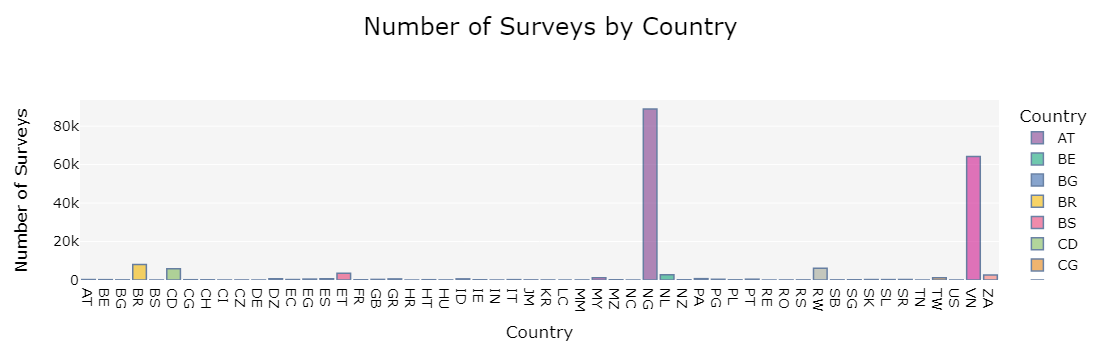

In [31]:
df_country = df.groupby('Country').size().reset_index(name='Count')

fig = px.bar(
    df_country,
    x='Country',
    y='Count',
    title='Number of Surveys by Country',
    labels={'Count':'Number of Surveys', 'Country':'Country'},
    color='Country',
    color_discrete_sequence=px.colors.qualitative.Bold  # Use a bold color sequence
)

fig.update_layout(
    title={
        'text': 'Number of Surveys by Country',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
            'size': 24
        }
    },
    xaxis_title="Country",
    yaxis_title="Number of Surveys",
    plot_bgcolor='#f5f5f5',  # Light grey background
    paper_bgcolor='#ffffff',  # White background
    font=dict(
        size=14,
        color='#000000'
    ),
    bargap=0.2  # Gap between bars
)

fig.update_traces(
    #texttemplate='%{y}',
    textposition='outside',
    marker_line_color='rgb(8,48,107)',  # Dark blue borders for bars
    marker_line_width=1.5,
    opacity=0.6
)

fig.show()

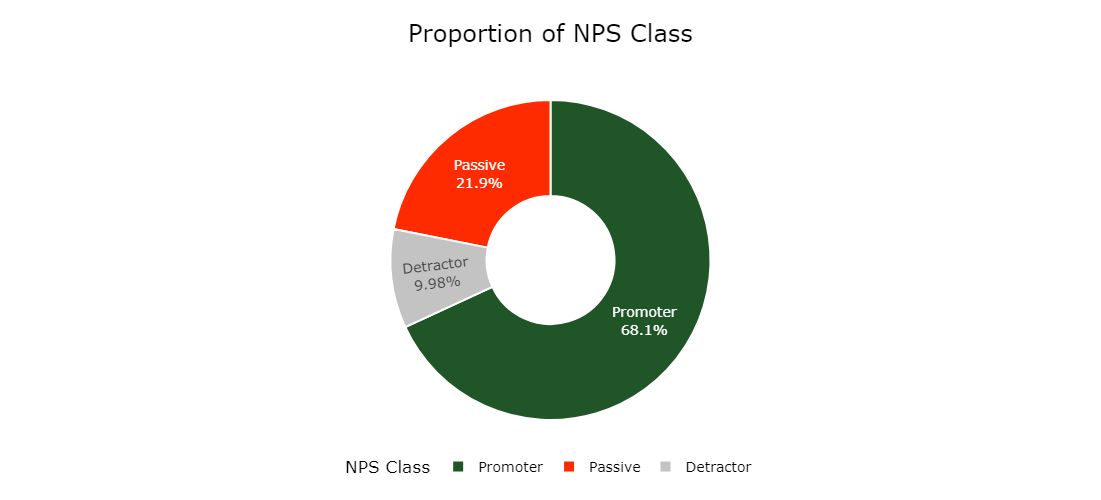

In [29]:
df_NPS = df.groupby('NPS_Class').size().reset_index(name='Count')

color_map = {
    'Promoter': '#205527', 
    'Passive': '#FF2B00',  
    'Detractor': '#C3C3C3' 
}

fig = px.pie(
    df_NPS,
    names='NPS_Class',
    values='Count',
    color='NPS_Class',
    color_discrete_map=color_map,
    title='Proportion of NPS Class',
    hole=0.4  # Adding a hole to make it a donut chart
)

fig.update_layout(
    width = 500,
    height = 500,
    title={
        'text': 'Proportion of NPS Class',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
            'size': 24
        }
    },
    legend_title_text='NPS Class',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5
    ),
    plot_bgcolor='#f5f5f5',  # Light grey background
    paper_bgcolor='#ffffff',  # White background
    font=dict(
        size=14,
        color='#000000'
    )
)

fig.update_traces(
    textinfo='percent+label',
    textfont_size=14,
    marker=dict(
        line=dict(color='#ffffff', width=2)
    ),
    hoverinfo='label+percent+value'
)

fig.show()

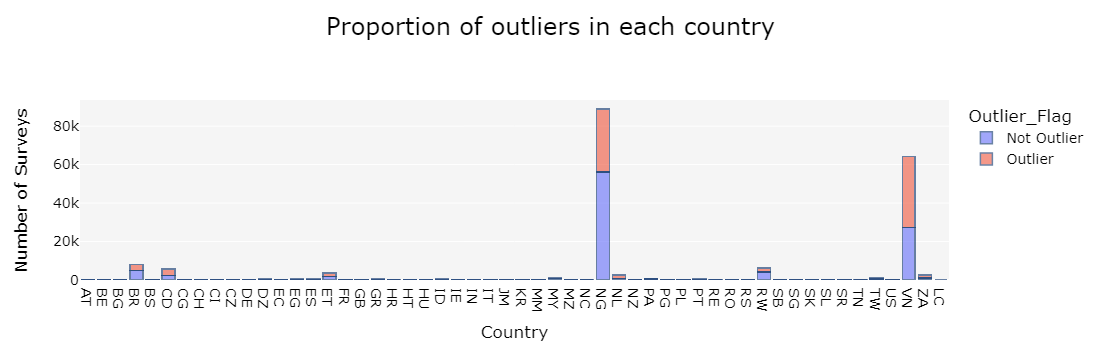

In [27]:
df_outlier_prop = df.copy()

df_outlier_prop['Outlier_Flag'] = df_outlier_prop['Old_Topic'].apply(lambda x: 'Outlier' if x == -1 else 'Not Outlier')

df_outlier_prop = df_outlier_prop.groupby(['Country', 'Outlier_Flag']).size().reset_index(name='Count')

fig = px.bar(df_outlier_prop, 
             x='Country', 
             y='Count', 
             color='Outlier_Flag', 
             title='Surveys per Country (Split by Outlier and Not Outlier)',
             labels={'Count': 'Number of Surveys', 'Country': 'Country'},
             barmode='stack')

fig.update_layout(
    title={
        'text': 'Proportion of outliers in each country',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
            'size': 24
        }
    },
    #xaxis_title="Country",

    xaxis=dict(
    title='Country',
    tickmode='linear'),
    
    yaxis_title="Number of Surveys",
    plot_bgcolor='#f5f5f5',
    paper_bgcolor='#ffffff',
    font=dict(
        size=14,
        color='#000000'
    ),
    bargap=0.2  # Gap between bars
)

fig.update_traces(
    #texttemplate='%{y}',
    textposition='outside',
    marker_line_color='rgb(8,48,107)',
    marker_line_width=1.5,
    opacity=0.6
)

fig.show()

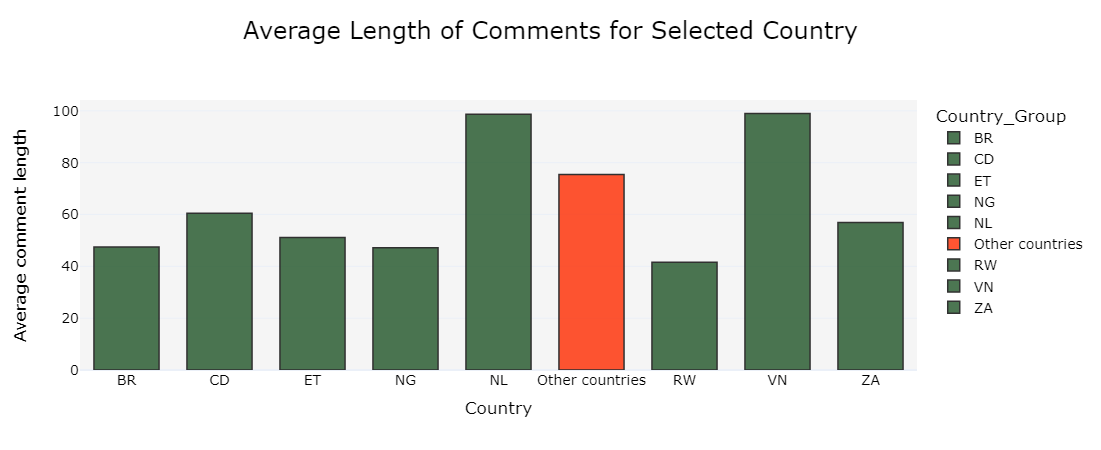

In [69]:
df_outlier_len = df.copy()
df_outlier_len['Comment_Translation'] = df_outlier_len['Comment_Translation'].astype('str')
selected_countries = ["BR", "CD", "ET", "NG", "NL", "RW", "VN", "ZA"]

df_outlier_len['Country_Group'] = df_outlier_len['Country'].apply(lambda x: x if x in selected_countries else 'Other countries')

df_outlier_len['Comment_Length'] = df_outlier_len['Comment_Translation'].apply(len)

avg_comment_length = df_outlier_len.groupby('Country_Group')['Comment_Length'].mean().reset_index()

color_map = {
    'Other countries': '#FF2B00',
    'BR': '#205527',
    'CD': '#205527',
    'ET': '#205527',
    'NG': '#205527',
    'NL': '#205527',
    'RW': '#205527',
    'VN': '#205527',
    'ZA': '#205527',
}

fig = px.bar(avg_comment_length, 
             x='Country_Group', 
             y='Comment_Length', 
             title='Average Length of Comments per Country',
             labels={'Comment_Length': 'Average Length of Comment', 'Country': 'Country'},
             template='plotly_white',
             color = "Country_Group",
            color_discrete_map=color_map)

fig.update_layout(
    width = 1100,
    height = 450,
    title={
        'text': 'Average Length of Comments for Selected Country',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
            'size': 24
        }
    },
    xaxis=dict(
    title='Country',
    tickmode='linear'),
    yaxis_title="Average comment length",
    plot_bgcolor='#f5f5f5',
    paper_bgcolor='#ffffff',
    font=dict(
        size=14,
        color='#000000'
    ),
    bargap=0.2
)

fig.update_traces(
    width = 0.7,
    #texttemplate='%{y}',
    textposition='outside',
    marker_line_color='black',
    marker_line_width=1.5,
    opacity=0.8
)

fig.show()

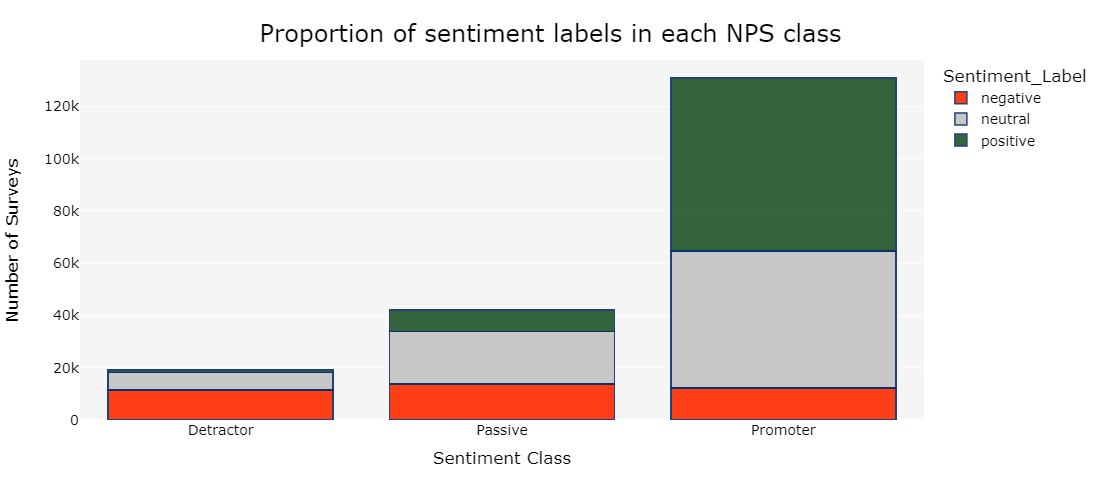

In [91]:
df_nps_sen = df.copy()
#display(df_nps_sen)

df_nps_sen = df_nps_sen.groupby(['NPS_Class', 'Sentiment_Label']).size().reset_index(name='Count')
#display(df_nps_sen)

color_map = {
    'positive': '#205527', 
    'negative': '#FF2B00',  
    'neutral': '#C3C3C3' 
}

fig = px.bar(df_nps_sen, 
             x='NPS_Class', 
             y='Count', 
             color='Sentiment_Label', 
             color_discrete_map=color_map,
             labels={'Count': 'Number of Surveys', 'Country': 'Country'},
             barmode='stack')

fig.update_layout(
    height = 500,
    width = 1000,
    title={
        'text': 'Proportion of sentiment labels in each NPS class',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
            'size': 24
        }
    },
    #xaxis_title="Country",

    xaxis=dict(
    title='Sentiment Class',
    tickmode='linear'),
    
    yaxis_title="Number of Surveys",
    plot_bgcolor='#f5f5f5',
    paper_bgcolor='#ffffff',
    font=dict(
        size=14,
        color='#000000'
    ),
    bargap=0.2  # Gap between bars
)

fig.update_traces(
    #texttemplate='%{y}',
    textposition='outside',
    marker_line_color='rgb(8,48,107)',
    marker_line_width=1.5,
    opacity=0.9
)

fig.show()

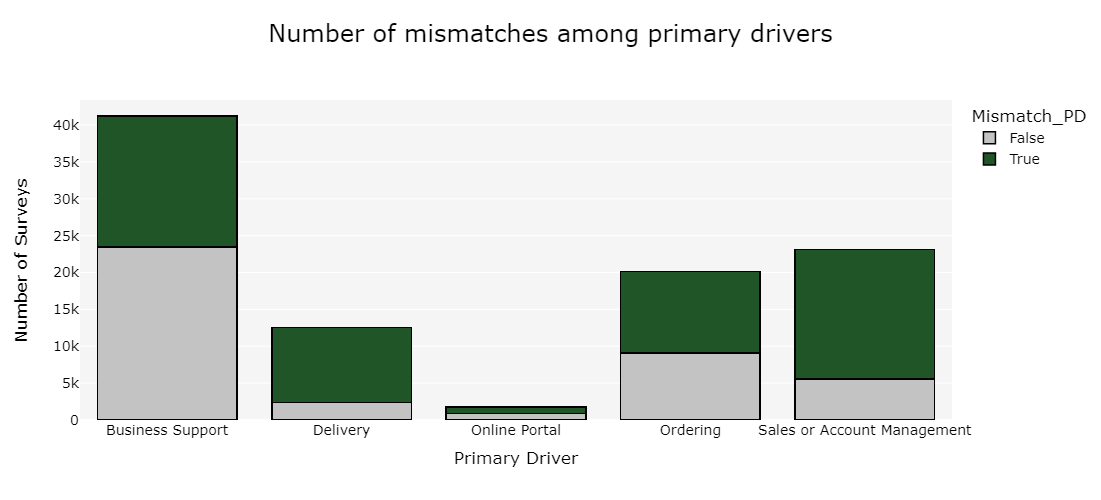

In [98]:
df_class = df.copy()

conditions = [
    df_class['Primary_Driver'] == 'Outlier',
    df_class['Primary_Driver'] == 'New Topic',
    df_class['Primary_Driver'] == 'No Topic'
]

choices = ['Outlier', 'New Topic', 'No Topic']

df_class['Class'] = np.select(conditions, choices, default='Existing Driver')

df_class = df_class[df_class['Class'] == 'Existing Driver']

df_class = df_class.groupby(['Primary_Driver', 'Mismatch_PD']).size().reset_index(name='Count')

fig = px.bar(df_class, 
             x='Primary_Driver', 
             y='Count', 
             color='Mismatch_PD',
             color_discrete_map={True: '#205527', False: '#C3C3C3'},
             title='Surveys per Country (Split by Outlier and Not Outlier)',
             labels={'Count': 'Number of Surveys', 'Country': 'Country'},
             barmode='stack')

fig.update_layout(
    height = 500,
    width = 1000,
    title={
        'text': 'Number of mismatches among primary drivers',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
            'size': 24
        }
    },
    #xaxis_title="Country",

    xaxis=dict(
    title='Primary Driver',
    tickmode='linear'),
    
    yaxis_title="Number of Surveys",
    plot_bgcolor='#f5f5f5',
    paper_bgcolor='#ffffff',
    font=dict(
        size=14,
        color='#000000'
    ),
    bargap=0.2  # Gap between bars
)

fig.update_traces(
    #texttemplate='%{y}',
    textposition='outside',
    marker_line_color='rgb(0,0,0)',
    marker_line_width=1.5,
    opacity=1
)

fig.show()


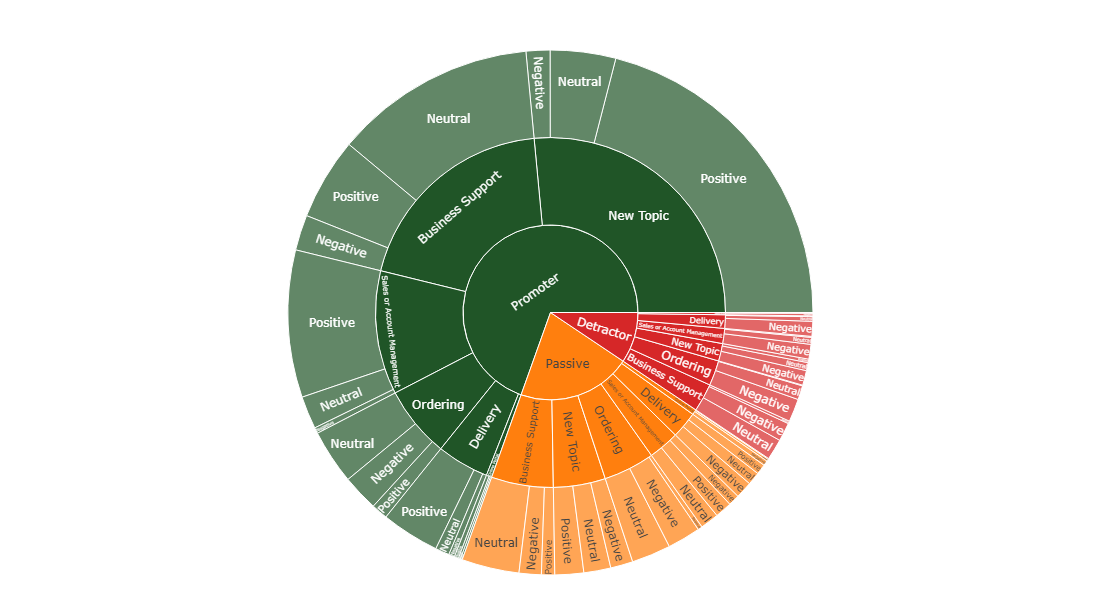

In [119]:
import plotly.express as px

color_map = {
    'Promoter': '#205527',
    'Passive': '#ff7f0e', 
    'Detractor': '#d62728',
}

df_sunburst = df.copy()
df_sunburst = df_sunburst[df_sunburst['Primary_Driver'] != 'Outlier']
df_sunburst = df_sunburst[df_sunburst['Primary_Driver'] != 'No Topic']
df_sunburst.replace({'negative': 'Negative',
                    'positive': 'Positive',
                    'neutral': 'Neutral'}, inplace = True)

fig = px.sunburst(
    df_sunburst,
    path=['NPS_Class',  'Primary_Driver', 'Sentiment_Label'],
    color='NPS_Class',
    color_discrete_map=color_map,
    height=600,
    width=800
)

fig.update_layout(
    sunburstcolorway=[
        '#1f77b4', '#ff7f0e', '#d62728', '#2ca02c', '#bcbd22', 
        '#9467bd', '#17becf', '#e377c2', '#8c564b', '#7f7f7f'
    ],
    margin=dict(t=50, l=25, r=25, b=25)
)

fig.show()

In [59]:
df.to_csv('Final_Results.csv', encoding = 'utf_8_sig', index = False)